### 销量预测-----lstm年预测模型
说明:每个月份横向预测，同时预测下一年12个月份的数据。如利用201401、201501、201601、201701、201801预测201901

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

pd.set_option('precision',4) #设置精度
pd.set_option('display.float_format', lambda x: '%.4f' % x)  

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
#模型训练+预测函数
def model_run(dataframe):
    max_col=dataframe.shape[1]-1
    dataset = dataframe.values
    
    #data normalization
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset[:,0:max_col].reshape(-1,1)).reshape(-1,max_col) 

    #train test split 
    trainX,trainY = dataset[:,0:(max_col-1)],dataset[:,max_col-1]
    testX = dataset[:,1:max_col]
    trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
    testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

    #build and train LSTM model
    model = Sequential()
    model.add(LSTM(50,input_shape = (1,max_col-1)))
    model.add(Dense(1))
    model.compile(loss = "mape",optimizer = "adam") #mean_squared_error
    model.fit(trainX,trainY,epochs = 100,batch_size = 2,verbose = 0)

    #prediction
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    #invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])    
    testPredict = scaler.inverse_transform(testPredict)

    predict_data=pd.DataFrame(np.reshape(testPredict,dataset.shape[0],1))
    
    return trainPredict,predict_data

In [3]:
#模型调用及结果展示
def lstm_year_predict(path,predict_var,n_inter):
    dataset = pd.read_csv(path, header=0, index_col=0)

    dataframe=pd.DataFrame(pd.pivot_table(dataset[['year','month',predict_var]],index=['year','month']).unstack(['year']).values,columns=['Y14','Y15','Y16','Y17','Y18'])
    ##构造19年数据
    dataframe['Y19']=np.nan
    dataframe_bak=copy.deepcopy(dataframe)
    compare_data_total_year= pd.DataFrame()


    #预测结果
    for i in range(n_inter) :
        trainPredict,compare_data=model_run(dataframe)
        compare_data_total_year= compare_data if compare_data_total_year.empty else pd.concat([compare_data_total_year,compare_data],axis=1)

    print('预测结果')
    print(compare_data_total_year.mean(axis=1))

    print('训练结果')
    train_result=pd.concat([pd.Series(dataframe_bak.iloc[:,-2]),pd.Series(trainPredict.reshape(1,dataframe_bak.shape[0])[0])],axis=1)
    train_result.columns=['true_data','predict_data']
    train_result['error_rate']=1-train_result.predict_data/train_result.true_data
    print(train_result)
    print('训练结果率',abs(train_result.error_rate).mean())


    plt.plot(train_result.true_data,'.-g',train_result.predict_data,'.-b')
    plt.title("true_data vs predict_data")
    plt.xlabel("Month")
    plt.ylabel("Sales Data")
    plt.legend(train_result.columns[:2],loc = "left center")
    plt.show()

### 模型运行

预测变量: y
预测结果
0    2225616.5000
1    1567740.5000
2    1769073.2500
3    1740399.7500
4    1817726.0000
5    1752740.7500
6    1821114.7500
7    1932977.5000
8    2074673.6250
9    2018297.5000
10   2190426.2500
11   2803681.5000
dtype: float32
训练结果
      true_data  predict_data  error_rate
0  2214261.0000  2180422.2500      0.0153
1  1603621.0000  1589802.6250      0.0086
2  1688752.0000  1647241.8750      0.0246
3  1624338.0000  1687296.7500     -0.0388
4  1756390.0000  1726074.3750      0.0173
5  1564237.0000  1636502.2500     -0.0462
6  1733312.0000  1712377.7500      0.0121
7  1844989.0000  1760130.1250      0.0460
8  1897910.0000  1916826.6250     -0.0100
9  1833529.0000  1895427.0000     -0.0338
10 1874986.0000  1988003.8750     -0.0603
11 2566147.0000  2497701.7500      0.0267
训练结果率 0.028287054533685057


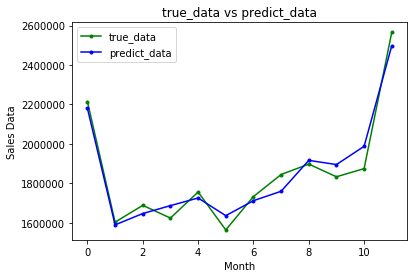

预测变量: y_joint
预测结果
0     987950.6250
1     708614.6250
2     856742.1250
3     841993.2500
4     881539.5000
5     846989.8750
6     888706.5000
7     942379.0000
8     992131.6250
9     951700.3125
10   1016592.1250
11   1257449.8750
dtype: float32
训练结果
      true_data  predict_data  error_rate
0  1066821.0000  1058138.1250      0.0081
1   731561.0000   726474.6875      0.0070
2   874304.0000   840029.1875      0.0392
3   842556.0000   847829.3750     -0.0063
4   886387.0000   882123.3750      0.0048
5   796150.0000   835662.3125     -0.0496
6   918942.0000   873856.0625      0.0491
7   976291.0000   913664.9375      0.0641
8   987522.0000   979042.9375      0.0086
9   946533.0000   944497.0625      0.0022
10  964466.0000  1003790.0000     -0.0408
11 1262767.0000  1252945.0000      0.0078
训练结果率 0.023957512425757038


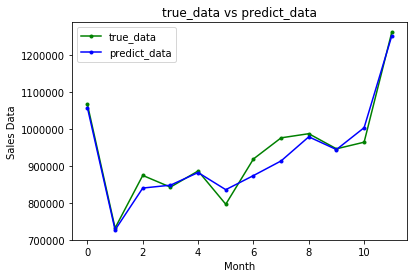

预测变量: y_independent
预测结果
0     798711.6875
1     596846.7500
2     618256.3750
3     603742.5000
4     630326.2500
5     611020.2500
6     632843.4375
7     672313.6875
8     724089.1250
9     728614.3125
10    790370.6875
11   1036003.5000
dtype: float32
训练结果
      true_data  predict_data  error_rate
0   870218.0000   768112.5000      0.1173
1   708573.0000   606207.2500      0.1445
2   595184.0000   574365.2500      0.0350
3   567573.0000   573355.5000     -0.0102
4   656883.0000   584464.5625      0.1102
5   560190.0000   565473.5000     -0.0094
6   574905.0000   586900.0000     -0.0209
7   606767.0000   607654.0000     -0.0015
8   650229.0000   662924.6875     -0.0195
9   662179.0000   679811.6875     -0.0266
10  666784.0000   719807.3750     -0.0795
11 1022719.0000   916258.0625      0.1041
训练结果率 0.05656176126469752


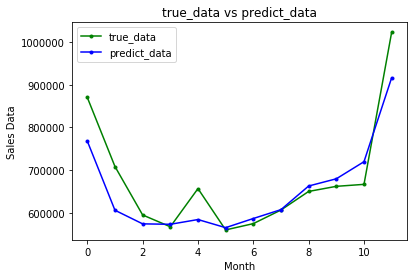

预测变量: y_luxury
预测结果
0    269147.3750
1    182624.3750
2    236025.3125
3    231078.3438
4    236447.1875
5    235190.5312
6    245660.6719
7    263024.0312
8    273733.0000
9    242603.6250
10   265270.5625
11   299019.4062
dtype: float32
训练结果
     true_data  predict_data  error_rate
0  277222.0000   241625.1094      0.1284
1  163487.0000   163572.4844     -0.0005
2  219264.0000   217266.1406      0.0091
3  214209.0000   214815.6250     -0.0028
4  213120.0000   221599.2656     -0.0398
5  207897.0000   218988.3438     -0.0534
6  239465.0000   223189.3281      0.0680
7  261931.0000   233881.4531      0.1071
8  260159.0000   252871.1719      0.0280
9  224817.0000   223493.4688      0.0059
10 243736.0000   245962.6094     -0.0091
11 280661.0000   281037.8750     -0.0013
训练结果率 0.037786778869001315


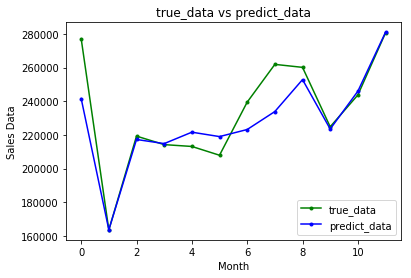

In [5]:
#参数
path='./predict_data_final.csv'  #数据路径
n_inter=20  #模型循环次数
year_predict_var=['y','y_joint','y_independent','y_luxury'] #预测变量
for i in year_predict_var:
    print('预测变量:',i)
    lstm_year_predict(path,i,n_inter)